#Read the data

In [2]:
from zipfile import ZipFile
import os, glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from google.colab.patches import cv2_imshow

In [3]:
!wget https://www.dropbox.com/s/gtvw3nqbderxigb/datafig28.zip

--2022-01-13 07:49:12--  https://www.dropbox.com/s/gtvw3nqbderxigb/datafig28.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6030:18::a27d:5012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/gtvw3nqbderxigb/datafig28.zip [following]
--2022-01-13 07:49:13--  https://www.dropbox.com/s/raw/gtvw3nqbderxigb/datafig28.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca34961cc38313d1a8a55e43c67.dl.dropboxusercontent.com/cd/0/inline/BduK7oj7cDqZXKsO7qsydqEOzSYL_Lxe79zAEwJCXfRiX_TO6WZlkpZUH2_GGfvFuVMqnj1OkWXHJsfKvkAqB8yTBpKTKPwdqLcNVZLf5kSfQqkOoftUnuy_so00VoC6kHhW6_I0IPN3B6Ht5G3milEh/file# [following]
--2022-01-13 07:49:13--  https://uca34961cc38313d1a8a55e43c67.dl.dropboxusercontent.com/cd/0/inline/BduK7oj7cDqZXKsO7qsydqEOzSYL_Lxe79zAEwJCXfRiX_TO6WZlkpZUH2_GGfvFuVMqnj1OkWXHJsfKvkAq

In [4]:
with ZipFile("datafig28.zip","r") as zip_ref:
    zip_ref.extractall()

36
24
12


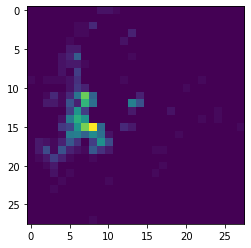

In [5]:
def imageread(directory, mode=all):
  if mode == "all":
    directory = directory+'all/'
  elif mode == "train":
    directory = directory+'train/'
  elif mode == "test":
    directory = directory+'test/'
  else:
    print("ERROR, You did not select a mode; must be one of these: all, train, test")

  modelen = next(os.walk(directory))[2] #dir is your directory path as string
  modelen = len(modelen)
  print(modelen)
  picmat = np.zeros([modelen,28,28])
  i = 0

  if mode != None:
    for files in os.scandir(directory):
      #print(files.path)
      imageArray = cv2.imread(files.path, cv2.COLOR_BGR2GRAY)
      picmat[i] = imageArray
      #cv2_imshow(picmat[i])
      i+=1

  return picmat
    
all3darr = imageread('/content/datafig28/', 'all')
train3darr = imageread('/content/datafig28/', 'train')
test3darr = imageread('/content/datafig28/', 'test')
plt.imshow(all3darr[0])

#Define the model (TFK-LSGAN)

In [6]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
import tensorflow as tf
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.initializers import RandomNormal
from matplotlib import pyplot

# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# define model
	model = Sequential()
	# downsample to 14x14
	model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, input_shape=in_shape))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 7x7
	model.add(Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dense(1, activation='linear', kernel_initializer=init))
	# compile model with L2 loss
	model.compile(loss='mse', optimizer=Adam(learning_rate=0.001, beta_1=0.5))
	return model

# define the standalone generator model
def define_generator(latent_dim):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# define model
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 256 * 7 * 7
	model.add(Dense(n_nodes, kernel_initializer=init, input_dim=latent_dim))
	model.add(BatchNormalization())
	model.add(Activation('relu'))
	model.add(Reshape((7, 7, 256)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(Activation('relu'))
	# upsample to 28x28
	model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(Activation('relu'))
	# output 28x28x1
	model.add(Conv2D(1, (7,7), padding='same', kernel_initializer=init))
	model.add(Activation('tanh'))
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	for layer in discriminator.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model with L2 loss
	model.compile(loss='mse', optimizer=Adam(learning_rate=0.001, beta_1=0.5))
	return model

# load our images #LOAD RAW IMAGES
def load_real_samples():
	# load dataset
	trainX = train3darr
	# expand to 3d, e.g. add channels
	X = expand_dims(trainX, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1] (activation = tanh)
	X = (X - 127.5) / 127.5
	return X

# # select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# select images
	X = dataset[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((n_samples, 1))
	return X, y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=12):
	# prepare fake examples
	X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot images
	for i in range(3 * 4):
		# define subplot
		pyplot.subplot(3, 4, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename1 = 'generated_plot_%06d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('Saved %s and %s' % (filename1, filename2))
  

# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist):
	pyplot.plot(d1_hist, label='dloss1')
	pyplot.plot(d2_hist, label='dloss2')
	pyplot.plot(g_hist, label='gloss')
	pyplot.legend()
	filename = 'plot_line_plot_loss.png'
	pyplot.savefig(filename)
	pyplot.close()
	print('Saved %s' % (filename))

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=9):
	# calculate the number of batches per training epoch
	bat_per_epo = int(dataset.shape[0] / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# calculate the size of half a batch of samples
	half_batch = int(n_batch / 2)
	# lists for storing loss, for plotting later
	d1_hist, d2_hist, g_hist = list(), list(), list()
	# manually enumerate epochs
	for i in range(n_steps):
		# prepare real and fake samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		print(X_fake.shape)
		# update discriminator model
		d_loss1 = d_model.train_on_batch(X_real, y_real)
		d_loss2 = d_model.train_on_batch(X_fake, y_fake)
		# update the generator via the discriminator's error
		z_input = generate_latent_points(latent_dim, n_batch)
		y_real2 = ones((n_batch, 1))
		g_loss = gan_model.train_on_batch(z_input, y_real2)
		# summarize loss on this batch
		print('>%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, d_loss1, d_loss2, g_loss))
		# record history
		d1_hist.append(d_loss1)
		d2_hist.append(d_loss2)
		g_hist.append(g_loss)
		# evaluate the model performance every 'epoch'
		if (i+1) % (bat_per_epo * 1) == 0:
			summarize_performance(i, g_model, latent_dim)
	# create line plot of training history
	plot_history(d1_hist, d2_hist, g_hist)

# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
print(dataset.shape)
# train model
train(generator, discriminator, gan_model, dataset, latent_dim)

(24, 28, 28, 1)
(4, 28, 28, 1)
>1, d1=2.246, d2=1.120 g=0.783
(4, 28, 28, 1)
>2, d1=289.814, d2=3.082 g=1.212
Saved generated_plot_000002.png and model_000002.h5
(4, 28, 28, 1)
>3, d1=1.231, d2=0.596 g=2.247
(4, 28, 28, 1)
>4, d1=23.375, d2=0.268 g=1.577
Saved generated_plot_000004.png and model_000004.h5
(4, 28, 28, 1)
>5, d1=1.089, d2=2.002 g=4.678
(4, 28, 28, 1)
>6, d1=1.429, d2=3.886 g=6.115
Saved generated_plot_000006.png and model_000006.h5
(4, 28, 28, 1)
>7, d1=0.139, d2=27.358 g=11.540
(4, 28, 28, 1)
>8, d1=0.374, d2=29.066 g=0.038
Saved generated_plot_000008.png and model_000008.h5
(4, 28, 28, 1)
>9, d1=0.262, d2=14.392 g=0.453
(4, 28, 28, 1)
>10, d1=0.111, d2=1.043 g=1.867
Saved generated_plot_000010.png and model_000010.h5
(4, 28, 28, 1)
>11, d1=0.094, d2=0.363 g=0.138
(4, 28, 28, 1)
>12, d1=0.079, d2=0.595 g=0.114
Saved generated_plot_000012.png and model_000012.h5
(4, 28, 28, 1)
>13, d1=0.054, d2=0.063 g=0.076
(4, 28, 28, 1)
>14, d1=0.366, d2=0.094 g=0.294
Saved generated_

Calculate train metrics

In [54]:
def reverse_tanh(nparray, maxcolour=44): #44 stands for maximum colour magnitude of a monthly raster, whilst 11 stands for the daily one.
  nparray = nparray.astype('float32')
  coeff = float(0.5*maxcolour)
  ones = np.ones_like(nparray)
  new_arr = (nparray + ones)*(coeff)
  return new_arr

In [55]:
gt, _ = generate_real_samples(dataset, 24)
pred, _= generate_fake_samples(generator, latent_dim, 24)

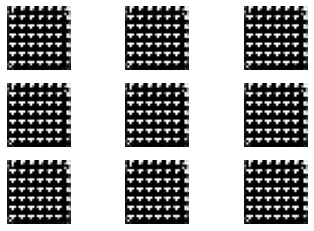

In [32]:
#Alternatively, you can try this block instead of the simple "pred,_"
"""from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# create a plot of generated images (reversed grayscale)
def plot_generated(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()
 
# load model
model = load_model('/content/model_000200.h5')
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# plot the result
plot_generated(X, 3)
# randomise X to calculate metrics
selectseq1 = np.random.choice(100, 24, replace=False)
selectseq2 = np.random.choice(100, 12, replace=False)
pred1 = np.zeros([24,28,28,1])
pred2 = np.zeros([24,28,28,1])
for i in range (0,24,1):
  pred1[i,:,:,:] = X[selectseq1[i],:,:,:]
for i in range (0,12,1):
  pred2[i,:,:,:] = X[selectseq2[i],:,:,:]"""

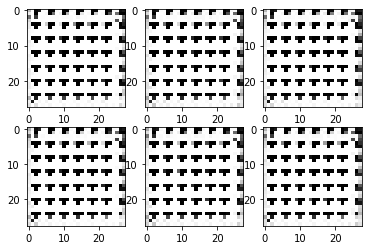

In [56]:
pred = pred.reshape(24,28,28)
fig, axs = plt.subplots(2, 3)
axs[0, 0].imshow(pred[0], cmap='gray')
axs[0, 1].imshow(pred[1], cmap='gray')
axs[0, 2].imshow(pred[2], cmap='gray')
axs[1, 0].imshow(pred[3], cmap='gray')
axs[1, 1].imshow(pred[4], cmap='gray')
axs[1, 2].imshow(pred[5], cmap='gray')

In [57]:
print("GT:", gt.shape, "||", gt.min(), "||", gt.max())
print("GT:", pred.shape, "||", pred.min(), "||", pred.max())
gt = gt.reshape(24,784)
gt = reverse_tanh(gt)
pred = pred.reshape(24,784)
pred = reverse_tanh(pred)
print("GT:", gt.shape, "||", gt.min(), "||", gt.max())
print("GT:", pred.shape, "||", pred.min(), "||", pred.max())

GT: (24, 28, 28, 1) || -1.0 || 1.0
GT: (24, 28, 28) || -0.9999985 || 1.0
GT: (24, 784) || 0.0 || 44.0
GT: (24, 784) || 3.2782555e-05 || 44.0


In [58]:
from sklearn import metrics
from math import sqrt

mae = metrics.mean_absolute_error(gt, pred)
mse = metrics.mean_squared_error(gt, pred)
mape = metrics.mean_absolute_percentage_error(gt, pred)
rmse = sqrt(mse)

print('MSE=', mse, '...RMSE=', rmse, '...MAE=', mae, '...MAPE=', mape)

MSE= 1385.0496 ...RMSE= 37.21625398326483 ...MAE= 32.86514 ...MAPE= 1.2789753e+17


Calculate test metrics

In [59]:
def load_test_samples():
	# load dataset
	testX = test3darr
	# expand to 3d, e.g. add channels
	X = expand_dims(testX, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

In [60]:
testd = load_test_samples()
print(testd.shape)

(12, 28, 28, 1)


In [61]:
gt, _ = generate_real_samples(testd, 12)
pred, _= generate_fake_samples(generator, latent_dim, 12)

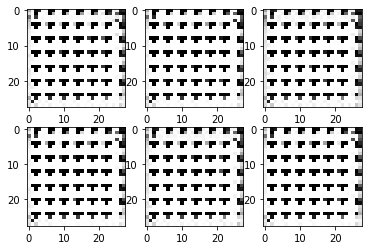

In [63]:
pred = pred.reshape(12,28,28)
fig, axs = plt.subplots(2, 3)
axs[0, 0].imshow(pred[0], cmap='gray')
axs[0, 1].imshow(pred[1], cmap='gray')
axs[0, 2].imshow(pred[2], cmap='gray')
axs[1, 0].imshow(pred[3], cmap='gray')
axs[1, 1].imshow(pred[4], cmap='gray')
axs[1, 2].imshow(pred[5], cmap='gray')

In [66]:
print("GT:", gt.shape, "||", gt.min(), "||", gt.max())
print("GT:", pred.shape, "||", pred.min(), "||", pred.max())
gt = gt.reshape(12,784)
gt = reverse_tanh(gt)
pred = pred.reshape(12,784)
pred = reverse_tanh(pred)
print("GT:", gt.shape, "||", gt.min(), "||", gt.max())
print("GT:", pred.shape, "||", pred.min(), "||", pred.max())

GT: (12, 28, 28, 1) || -1.0 || 0.8666667
GT: (12, 28, 28) || -0.9999959 || 1.0
GT: (12, 784) || 0.0 || 41.066666
GT: (12, 784) || 9.047985e-05 || 44.0


In [67]:
from sklearn import metrics
from math import sqrt

mae = metrics.mean_absolute_error(gt, pred)
mse = metrics.mean_squared_error(gt, pred)
mape = metrics.mean_absolute_percentage_error(gt, pred)
rmse = sqrt(mse)

print('MSE=', mse, '...RMSE=', rmse, '...MAE=', mae, '...MAPE=', mape)

MSE= 1382.266 ...RMSE= 37.178837948636016 ...MAE= 32.839905 ...MAPE= 1.2829463e+17
